In [1]:
# NumPy and odeint, our workhorses
import numpy as np
import scipy.integrate
import numba
import eqtk
import pandas as pd
from matplotlib.colors import LogNorm
import bokeh.io
import bokeh.plotting

bokeh.io.output_notebook()

# # For interactive plots
# import ipywidgets

# Import plotting stuff
import matplotlib.pyplot as plt
import seaborn as sns
# Set matplotlib rc params.
rc = {'lines.linewidth' : 2, 'axes.labelsize' : 20, 'legend.fontsize': 12,
        'axes.titlesize' : 25, 'xtick.labelsize': 15, 'ytick.labelsize': 15}

sns.set(rc=rc)
sns.set_style("whitegrid")

%load_ext blackcellmagic
%matplotlib inline

Loading BokehJS ...

In [2]:
def assess_steady_state_convergence(RLN, interval, convergence_crit):
    """Determines whether the system has reached
    steady-state."""
    
    converged = True
    
    # Compute gradient across last hour and compute percent difference
    
    back_idx = int(60 / interval + 1)
    
    # initialize
    (R_err, L_err, N_err) = (0.0, 0.0, 0.0)
    
    # Replace values while avoiding divide by zero errors
    # Multiply by 100 to get percent difference
    if RLN[-1,0] != 0:
        R_err = 100 * abs(RLN[-1,0] - RLN[-back_idx,0]) / RLN[-1,0]
    if RLN[-1,1] != 0:
        L1_err = 100 * abs(RLN[-1,1] - RLN[-back_idx,1]) / RLN[-1,1]
    if RLN[-1,2] != 0:
        L2_err = 100 * abs(RLN[-1,2] - RLN[-back_idx,2]) / RLN[-1,2]
    
    RLN_err = np.array((R_err, L_err, N_err))
    
    # Evaluate convergence   
    failed_arr = RLN_err > convergence_crit
    
    if np.sum(failed_arr) > 0:
#         print('The system has not reached steady state.')
        
        converged = False
        
    return converged

In [3]:
def solve_EQTK(c0_vect, stoich, K_vect):
    '''Takes in:
    - c0_vect = initial concentrations of all species in proper order
    - stoichiometric matrix
    - K_vect = list of Kd values in proper order '''

    N = stoich
    
    c = eqtk.solve(c0_vect, N, K_vect, units=None)
    
    R, Lt, Lc, C_plus, C_minus = c #all of the steady state concentrations after equilibrium is reached 
    
    # Sanity check of mass conservation:
    Rtot = c0_vect[0]
         
    return c

In [4]:
def plot_dynamics(t, y_vals, normalized=False, 
                  normalize_to_max=True, leg_loc='center right', 
                  leg_lab = ('Total receptor','Total ligand',
                             'Activated receptor','Trans R:L complex'),
                  xlab = 'time (hr)', ylim = False,
                  ylab = 'dimensionless conc.', title = '',
                 filesave = 'NA'):
    """Convenient plotting function for results"""
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 6))
    
    # Get plot of stimulus dynamics

    if normalized:
        ylab = 'normalized ' + ylab
        if normalize_to_max:
            ax = plt.plot(t, y_vals[:,0]/y_vals[:,0].max())
            ax = plt.plot(t, y_vals[:,1]/y_vals[:,1].max())
            ax = plt.plot(t, y_vals[:,2]/y_vals[:,2].max())
            if np.shape(y_vals)[1] > 3:
                ax = plt.plot(t, y_vals[:,3]/y_vals[:,3].max())
            if np.shape(y_vals)[1] > 4:
                ax = plt.plot(t, y_vals[:,4]/y_vals[:,4].max())

        else:
            ax = plt.plot(t, y_vals[:,0]/y_vals[-1,0])
            ax = plt.plot(t, y_vals[:,1]/y_vals[-1,1])
            ax = plt.plot(t, y_vals[:,2]/y_vals[-1,2])
            if np.shape(y_vals)[1] > 3:
                ax = plt.plot(t, y_vals[:,3]/y_vals[-1,3])
            if np.shape(y_vals)[1] > 4:
                ax = plt.plot(t, y_vals[:,4]/y_vals[-1,4])

    else:
        ax = plt.plot(t, y_vals[:,0])
        ax = plt.plot(t, y_vals[:,1])
        ax = plt.plot(t, y_vals[:,2])
        if np.shape(y_vals)[1] > 3:
            ax = plt.plot(t, y_vals[:,3])
        if np.shape(y_vals)[1] > 4:
            ax = plt.plot(t, y_vals[:,4])

    plt.xlabel(xlab)
    plt.ylabel(ylab)
    if ylim != False:
        plt.ylim(ylim)
    plt.legend(leg_lab,loc=leg_loc, fontsize = 14)
    plt.title(title, size=22)
    
    if filesave != 'NA':
        print('image saved.')
        filename =  '/Users/catherineko/Desktop/FSRI/Research/temp/' + filesave +  '.pdf'
        plt.savefig(filename, bbox_inches='tight', format='pdf')
    
    return ax

In [5]:
def get_steady_state_vals(RLN, interval, convergence_crit):
    '''Extracts steady-state values from end
    of simulation and reports percent difference 
    across last hour of simulation to assist 
    evaluation of whether steady-state was reached.
    Convergence criterion is the maximum percent
    difference allowed before we say the system has 
    reached steady-state. E.g. 1 for one percent.'''
    
    # Compute steady state vals
    
    R0 = RLN[-1,0]
    L0 = RLN[-1,1]
    N0 = RLN[-1,2]
    
    RLN0 = np.array((R0, L0, N0)) 
    
    # Determine whether system has reached steady-state
    
    converged = assess_steady_state_convergence(RLN, interval, convergence_crit)
    
    if converged:
        return RLN0
    else:
        return np.array((np.nan, np.nan, np.nan))

In [6]:
def concat_initial_value(RLN, RLN_initial, hr, tpts):
    """Adds on initial value to simulation output
    in order to see how 'mixing' senders and receivers
    altered receptor and ligand levels.
    Can take RLN or RLNT of any shape as long as the
    dimensions of RLN and RLN_initial are compatible."""
    
    # concat on initial values
    RLN = np.concatenate((RLN_initial, RLN), axis = 0)
    
    # update t accordingly:
    t = np.linspace(0, hr + (hr/tpts), tpts+1)
    
    return RLN, t

In [7]:
def compute_cis_activation_potency(N_vect): #peak over leaky 
    '''This function returns the peak activation
    over leaky activation (latter assumed to be first 
    N-value).'''
    
    return np.around(np.max(N_vect) / N_vect[0], decimals = 2)

def compute_cis_inhibition_potency(N_vect):#??? metric of cis inhibition
    '''This function returns the inhibitory potential,
    defined as how close to 'leaky' activation the inhibitory
    ligand dampens the signal.
    This is expressed as a fraction, where 1 is the maximal
    inhibition possible, and 0 = no inhibition.'''
    
    # (peak activation - activation at highest cis ligand level) / 
    # (peak activation - leaky activation)
    
    cis_inh = 100 * (np.max(N_vect) - N_vect[-1]) / (np.max(N_vect) - N_vect[0])
    
    return np.around(cis_inh, decimals = 2)


In [8]:
def titrate_ligand(aL_vect, params, hr, interval, convergence_crit):
    '''This runs a series of simulations to calculate
    steady-state N (NICD) values for a range of ligand 
    levels.
    aL_vect is the range of ligand values to explore'''
    
    N_vect = []
    
    for aL in aL_vect:
        
        Kd_t, Kd_c, aR, gR, dR, gT, aL_prev, gL, gC, gN = params
        params = Kd_t, Kd_c, aR, gR, dR, gT, aL, gL, gC, gN
        
        # Simulate
        RLN_initial, RLN, t = simulate_Notch_signaling(params, hr, interval)
        
        # get steady state value
        RLN0 = get_steady_state_vals(RLN, interval, convergence_crit)
        N = RLN0[2]
        
        N_vect.append(N)
        
    # Determine cis-activation potency
    cis_act = compute_cis_activation_potency(N_vect)
    
    # Determine cis-inhibition potency???
    cis_inh = compute_cis_inhibition_potency(N_vect)
        
    return np.array(N_vect), cis_act, cis_inh
    

In [9]:
def logistic(x, max_Lt_frac, inflection_pt, curvature):
    """Returns y value of logistic function at 
    x value(s) provided based on three curve parameters."""

    return max_Lt_frac / (1 + np.exp(curvature * (x - inflection_pt)))

Text(0.5, 0, '$C^-$')

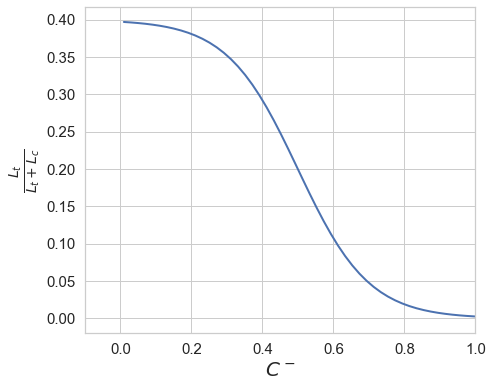

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

# x = np.around(np.logspace(1.5, 3.4, num=100, base=10.0), decimals=4)
x = np.linspace(0.01,2, num=100)

inflection_pt = .5

plt.plot(x, logistic(x, .4, inflection_pt, 5 * (1/inflection_pt)))
# plt.xscale('log')
# plt.ylim(0,.42)
plt.xlim(-.1,inflection_pt * 2)
# plt.ylabel("$L_t$ / ($L_t$ + $L_c$)")
plt.ylabel("$\\frac{L_t}{L_t + L_c}$")
plt.xlabel("$C^-$")

In [11]:
def populate_ligand_states(L, C_minus_prev):
    """Computes fraction of free ligand (including protein
    and membrane state) that exists in trans-like vs. cis-
    like state (Lt vs Lc, respectively). This fraction 
    is computed based on a logistic function defined by
    three parameters that you must pass it.
    Returns Lt_tot, Lc_tot."""
    
    max_Lt_frac = 0.4 # 40%
    inflection_pt = .05 # TEMPORARY! MUST CHANGE
    curvature = 5 * (1/inflection_pt) # try 5 * 
    
    frac_Lt = logistic(C_minus_prev, max_Lt_frac, inflection_pt, curvature)
    
    Lt = frac_Lt * L
    Lc = (1 - frac_Lt) * L
    
    return Lt, Lc
    
    # I like the idea of sampling from a binomial distribution, 
    # where theta is returned by the logistic function,
    # but I think it's unnecessarily complicated.
    
    

In [12]:
#ODES
def dN_dt(R, L, N, Rfree, Lt_free, Lc_free, C_p, C_m, circuit_params):
    """
    Dynamics of activated receptor (ICD); I'm passing
    all variables and parameters for easy editing as needed.
    """
    Kd_t, Kd_c, aR, gR, dR, gT, aL, gL, gC, gN = circuit_params
    return gT * C_p + dR * Rfree - gN * N


def dR_dt(R, L, N, Rfree, Lt_free, Lc_free, C_p, C_m, circuit_params):
    """
    Dynamics of surface receptor (total receptor); I'm passing
    all variables and parameters for easy editing as needed.
    """
    Kd_t, Kd_c, aR, gR, dR, gT, aL, gL, gC, gN = circuit_params
    return aR - gR * (R - C_m) - gC * C_m - gT * C_p - dR * Rfree


def dL_dt(R, L, N, Rfree, Lt_free, Lc_free, C_p, C_m, circuit_params):
    """
    Dynamics of surface ligand (total ligand); I'm passing
    all variables and parameters for easy editing as needed.
    """
    Kd_t, Kd_c, aR, gR, dR, gT, aL, gL, gC, gN = circuit_params
    return aL - gL * (Lt_free + Lc_free) - gR * C_p - gC * C_m - gT * C_p


In [13]:
def get_equilibrium_concentrations(R, Lt, Lc, circuit_params):
    """Gathers info needed to call EQTK
    and calls EQTK."""
    
    # Unpack params
    Kd_t, Kd_c, aR, gR, dR, gT, aL, gL, gC, gN = circuit_params
    
    # Stoichiometry matrix
    N_1_2 = [[1,  1,  0, -1,  0], #(1)R + (1)L_t + (0)L_c ⇌ (-1)C^+ + (0)C^-
         [1,  0,  1,  0, -1]] #(1)R + (0)L_t + (1)L_c ⇌ (0)C^+ + (-1)C^-
    
    # Array of Kd values
    K_vect = [Kd_t, Kd_c]

    # Initial concentration vector to pass to EQTK
    c0_vect = np.array((R, Lt, Lc, 0.0, 0.0)) # R_tot, Lt_tot, Lc_tot, C_plus, C_minus
    if np.isnan(c0_vect).any():
        print(c0_vect)
    neg = c0_vect[c0_vect < 0]
    if len(neg) > 0:
        print('negative found:', c0_vect)
        
    # Compute T based on R_tot and L_tot using EQTK
    Rfree, Lt_free, Lc_free, C_plus, C_minus = solve_EQTK(c0_vect, N_1_2, K_vect)
        
    return np.array([Rfree, Lt_free, Lc_free, C_plus, C_minus])

In [14]:
def Euler_integration(RLN_initial, circuit_params, dt, t_stop):    
    """
    Use Euler integration to solve ODEs
    for model of Notch cis interactions
    between one ligand and one receptor.
    """    

    # Time points
    t = np.linspace(0, t_stop, int(t_stop / dt) + 1)
    
    # Initialize output arrays
    R0, L0, N0 = RLN_initial
    #print('starting R, L, N at', R0, L0, N0)
    R = R0 * np.ones_like(t)
    L = L0 * np.ones_like(t)
    N = N0 * np.ones_like(t)
    C_minus = 0.0 * np.ones_like(t)
    
    # Do Euler stepping, preventing negative concentration values
    for i in range(0, len(t) - 1):
            
        # Compute fraction of ligand in 'trans-like' vs. 'cis-like' state
        # This must use prev value of C_minus, because current value is computed based on Lt, Lc
        Lt, Lc = populate_ligand_states(L[i], 0.0)
        if i > 0:
            Lt, Lc = populate_ligand_states(L[i], C_minus[i-1]) # Lt_tot, Lc_tot
        
        # Get equilibrium concentrations
        EQTK_output = get_equilibrium_concentrations(R[i], Lt, Lc, circuit_params)
        Rfree, Lt_free, Lc_free, C_p, C_m = EQTK_output # equilibrium concentrations at current step i
        
        # Add C_minus to array for CURRENT INDEX
        C_minus[i] = C_m
#         print('C_minus', C_m)
            
        # Compute new R
        R[i+1] = R[i] + dt * dR_dt(R[i], L[i], N[i], Rfree, Lt_free, Lc_free, C_p, C_m, circuit_params)
        if R[i+1] < 0:
            R[i+1] = 0
        
        # Compute new L
        L[i+1] = L[i] + dt * dL_dt(R[i], L[i], N[i], Rfree, Lt_free, Lc_free, C_p, C_m, circuit_params)
        if L[i+1] < 0:
            L[i+1] = 0
        
        # Compute new N
        N[i+1] = N[i] + dt * dN_dt(R[i], L[i], N[i], Rfree, Lt_free, Lc_free, C_p, C_m, circuit_params)
        if N[i+1] < 0:
            N[i+1] = 0
        
    # Concatenate arrays
    #print('final C_minus = ', C_m)
    RLN = np.concatenate(([R,], [L,], [N,]), axis=0)
    RLN = np.transpose(RLN)
        
    return RLN, t


In [15]:
def simulate_Notch_signaling(circuit_params, hr, interval):
    """Runs Euler integration and returns 
    initial values (initial steady state) as 
    well as simulation output (with total receptor
    and ligand, not free) and time series.
    Takes as input one set of circuit parameters 
    and values that define the time series:
    - hr (simulation duration in hr) 
    - interval (time step in minutes)
    """
    
    # Define time series
    dt = interval / 60 # convert interval from minutes to hours
    
    # Start values at steady state
    Kd_t, Kd_c, aR, gR, dR, gT, aL, gL, gC, gN = circuit_params
    R0 = aR/(gR + dR)
    L0 = aL/gL
    N0 = dR * R0 / gN
    RLN_initial = (R0, L0, N0) 
    
    # Initiate Euler stepping
    RLN, t = Euler_integration(RLN_initial, circuit_params, dt, hr)

    # Return initial values and simulation output
    return RLN_initial, RLN, t

In [186]:
def significant_change(aL_vals):
    """Creates array of 0,1,-1 values that represent no change, positive change, negative change respectively. 
    Used for peak_params to calculate whether a peak is occurring."""

    new_list = []

    for i, aL in enumerate(aL_vals):

        if (i + 1) <= len(aL_vals) - 1:
            change = N_vect[i + 1] - N_vect[i]
            
            if change > 0.05:
                new_list.append(1)
            if change < -0.1:
                new_list.append(-1)
            else: 
                new_list.append(0)

    new_array2 = np.array(new_list)

    return new_array2

In [169]:
significant_change(aL_vals)

array([ 0,  0,  1,  0,  1,  0, -1,  0])

In [182]:
def peak_params(aL_vals):
    """Gives peak_width, start of peak, end of peak in terms of aL"""

    start_of_peak = np.nan
    end_of_peak = np.nan
    peak_width = np.nan

    for i, element in enumerate(significant_change(aL_vals)):
        if element == 1:
            start_of_peak = aL_vals[i]
            break

    for i, element in reversed(list(enumerate(significant_change(aL_vals)))):
        if element == -1:
            #if i+1==len(aL_vals):
            end_of_peak=aL_vals[i-1]
            #if i+1<len(significant_change(aL_vals)):
                #end_of_peak = aL_vals[i+1]
            break

    if start_of_peak != 0.0:
        peak_width = end_of_peak / start_of_peak  # beware of Nan

    return peak_width, start_of_peak, end_of_peak

Cis-activation fold-diff: 68.67
Cis-inhibition efficacy: 0.0 %
start of peak 1.0
end of peak nan
peak_width nan
sig change [0 0 0 0 1 0 0]


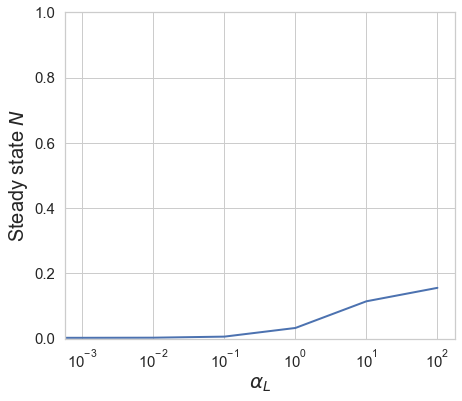

In [187]:
# Define ligand range for titration- x axis for plot; adding ligands 
aL_vals = np.around(np.logspace(-3, 2, num=6, base=10.0), decimals=4)
aL_vals = np.insert(aL_vals, 0, 0)

circuit_params = (Kd_t, Kd_c, aR, gR, dR, gT, aL_vals[0], gL, gC, gN)

# Define time series
hr = 48.0 # simulation of 48 hours
interval = 5 # 5 minutes between time steps

convergence_crit = 1 # ≤ 1 percent change in 5 minutes = steady state achieved

# Simulate ligand titration
N_vect, cis_act, cis_inh = titrate_ligand(aL_vals, circuit_params, 
                                          hr, interval, convergence_crit)

# Print cis-activation and -inhibition metrics
print('Cis-activation fold-diff:', cis_act)
print('Cis-inhibition efficacy:', cis_inh, '%')

# Added this in to quantify peak width 
peak_width,startpeak,endpeak=peak_params(aL_vals)
# Plot
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

plt.plot(aL_vals, N_vect)
plt.ylabel('Steady state $N$')
plt.xlabel('$\\alpha_L$')
plt.ylim((0,1))
ax.set_xscale('log')
print('start of peak', startpeak)
print('end of peak',endpeak)
print('peak_width',peak_width)
print('sig change',significant_change(aL_vals))

## Define the experiment

1. We want to determine whether this model (under any reasonable parameter set) could enable cis-activation at low ligand levels and cis-inhibition at high ligand levels. We will start by simulating the Notch1-Dll4 combination.

To do this, we must generate a series of ligand concentrations (a virtual 'titration'), and 
- visualize what the curve of N (active NICD) looks like across that range
- define cis-activation and cis-inhibition metrics to compare parameter sets
    - cis-activation: N fold difference over 'leaky' activation
    - cis-inhibition: how completely cis-activation is 'stopped' at the highest ligand concentration, i.e. ($N_a$ [val. at peak activation] - $N_I$ [val. max inhibition]) / ($N_a$ [val. at peak activation] - $N_L$ [leaky activation])
    

2. We next want to ask whether this model enables cis activation without inhibition when the $K_{d_c}$ corresponds to a very weak 'cis' affinity. This is my hypothesis for how Notch2 differs from Notch1 in its cis-interactions with Delta ligands.


Parameters / ranges:
- $K_{d_c}$ should be varied in the range of ($0.01$ to $10$)?.
- $K_{d_t}$ should be in the range of ($0.01$ to $0.1$), which is reasonable for the Notch1-Dll4 $K_d$ relative to the Dll1-Notch1 $K_d$.
- $\alpha_R$ could take a wide range of values, but use $0.06$ or $0.4$. 
    - From $10^{-3}$ or to $10^3$ (times degradation rates).
    - Remember, these values are relative to true Notch1-Dll1 Kd.
- $d_R = \frac{\log(2)}{10h}$ or somewhere between 5-20h.
- $\gamma_{R} = \frac{\log(2)}{0.8h}$
- $\alpha_{L}$ could take a wide range of values, but use $0.06$ or $0.4$. 
- $\gamma_{L} = \frac{\log(2)}{0.3h}$
- $\gamma_{T(1,2)} = \frac{\log(2)}{0.07h}$
- $\gamma_N$ is fixed at $\frac{\log(2)}{1.25}$

# Plotting aR, Kd_t, and Kd_c by peak width

In [19]:
Kd_t_vals = np.around(np.linspace(0.1,10,num=6),decimals =4)
Kd_c_vals = np.around(np.linspace(0.1,10,num=6),decimals =4)
aR_vals = np.around(np.linspace(.05, 0.15, num=6), decimals=4) # this range of aR values gives good curve
gR = np.log(2) / .8
dR = 0.01
gT = np.log(2) / .07
# aL = 0.4
gC = gR # setting gC == gR for now
gL = np.log(2) / .3
gN = np.log(2) / 1.25

# Dont run below cell unless reloading data

In [ ]:
%%time 
# Define params values that give good fold differences at reasonably high production rates
# Receptor = Notch1, Ligand = Dll4

master_array = np.array(())

for aR in aR_vals:
    for Kd_t in Kd_t_vals:
        for Kd_c in Kd_c_vals:

            # Define ligand range for titration- x axis for plot; adding ligands
            aL_vals = np.around(np.logspace(-3, 2, num=6, base=10.0), decimals=4)
            aL_vals = np.insert(aL_vals, 0, 0)

            circuit_params = (Kd_t, Kd_c, aR, gR, dR, gT, aL_vals[0], gL, gC, gN)

            # Define time series
            hr = 48.0  # simulation of 48 hours
            interval = 5  # 5 minutes between time steps

            # ≤ 1 percent change in 5 minutes = steady state achieved
            convergence_crit = 1

            # Simulate ligand titration
            N_vect, cis_act, cis_inh = titrate_ligand(
                aL_vals, circuit_params, hr, interval, convergence_crit
            )

            # Added this in to quantify peak width
            peak_width, startpeak, endpeak = peak_params(aL_vals)
            sig_change=significant_change(aL_vals)

            Kd_t, Kd_c, aR, gR, dR, gT, aL_vals[0], gL, gC, gN = circuit_params

            create_list = [
                Kd_t,
                Kd_c,
                aR,
                gR,
                dR,
                gT,
                aL_vals[0],
                gL,
                gC,
                gN,
                cis_act,
                cis_inh,
                startpeak,
                endpeak,
                peak_width,
                sig_change
            ]

            master_array = np.append(master_array, create_list)

In [ ]:
rows = master_array.size/16

In [ ]:
master_array = master_array.reshape((int(rows),16))

In [ ]:
masterdf = pd.DataFrame(master_array)

In [ ]:
masterdf.columns = ['Kd_t', 'Kd_c', 'aR', 'gR', 'dR', 'gT', 'aL_vals[0]', 'gL', 'gC', 'gN', 'cis_act','cis_inh', 'startpeak','endpeak','peak_width','sig_change']

In [ ]:
masterdf.head()

In [ ]:
filename = '/Users/cjko/git/bootcamp/2020-08-01_aR_Kdt_Kdc.csv'

masterdf.to_csv(filename, sep = ',', index=False)

### Read in data

In [126]:
file = '/Users/cjko/git/bootcamp/2020-08-01_aR_Kdt_Kdc.csv'
masterdf = pd.read_csv(file)

In [127]:
masterdf=masterdf.sort_values(by=['peak_width']).reset_index()

In [128]:
masterdf.head()

,index,Kd_t,Kd_c,aR,gR,dR,gT,aL_vals[0],gL,gC,gN,cis_act,cis_inh,startpeak,endpeak,peak_width,sig_change
0,85,4.06,2.08,0.09,0.866434,0.01,9.902103,0.0,2.310491,0.866434,0.554518,55.70,98.54,1.0,100.0,100.0,[ 0 0 0 0 1 -1 -1]
1,214,10.00,8.02,0.15,0.866434,0.01,9.902103,0.0,2.310491,0.866434,0.554518,49.11,101.71,1.0,100.0,100.0,[ 0 0 0 0 1 -1 -1]
2,170,8.02,4.06,0.13,0.866434,0.01,9.902103,0.0,2.310491,0.866434,0.554518,48.39,101.86,1.0,100.0,100.0,[ 0 0 0 0 1 -1 -1]
3,171,8.02,6.04,0.13,0.866434,0.01,9.902103,0.0,2.310491,0.866434,0.554518,51.83,101.57,1.0,100.0,100.0,[ 0 0 0 0 1 -1 -1]
4,172,8.02,8.02,0.13,0.866434,0.01,9.902103,0.0,2.310491,0.866434,0.554518,53.45,101.29,1.0,100.0,100.0,[ 0 0 0 0 1 -1 -1]


In [129]:
no_nan_df= masterdf[masterdf['peak_width'].notna()]

%%black -l 49

# Peak Width

In [26]:
def loopheatmaps(values,index,columns,loop,loopvals,startofloop=0,dataset=masterdf):
    """This function is for looping through creating a bunch of heat maps.
    values = what you want the color scale to represent STR
    index=y-axes STR
    columns=x-axis STR 
    loop= the variable staying constant that you are looping through for each map
    loopvals = ^ but the vals array
    startofloop = start of range; default = 0"""
    
    for i in range(startofloop,len(loopvals)):

        df_subset = dataset.loc[(dataset[str(loop)] == np.around(loopvals[i],decimals=4))]

        # I HAD A ROUNDING ERROR ^ BUT FIXED W NP.AROUND

        # I think dependence on aR == aL equivalence is only true for certain gR values. try gR = g_vals[3] vs [1]

        # pandas pivot
        heatmap_data = pd.pivot_table(df_subset, values=str(values), 
                             index=[str(index)], 
                             columns=str(columns))

        print('===============')
        print(str(loop),loopvals[i])
        sns.heatmap(heatmap_data,norm=LogNorm())
        df_subset
        plt.show()
        plt.figure()
        
    

aR 0.09


/Users/cjko/opt/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


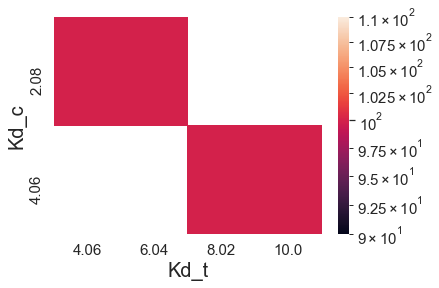

aR 0.11


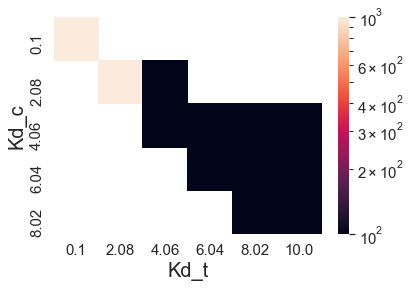

aR 0.13


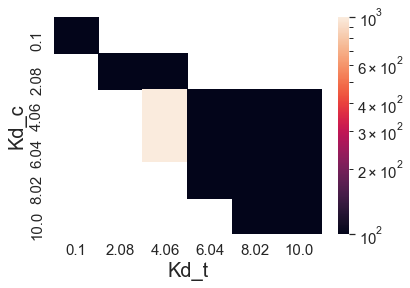

aR 0.15


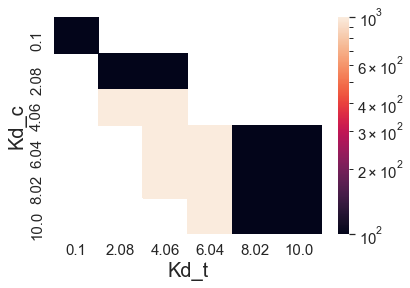

<Figure size 432x288 with 0 Axes>

In [27]:
loopheatmaps(
    values="peak_width",
    index="Kd_c",
    columns="Kd_t",
    loop="aR",
    loopvals=aR_vals,
    startofloop=2,
)

In [132]:
np.around(np.linspace(.05, 0.15, num=6), decimals=4),

(array([0.05, 0.07, 0.09, 0.11, 0.13, 0.15]),)

In [141]:
import bokeh.plotting
import bokeh.io

bokeh.io.output_notebook()

Loading BokehJS ...

In [184]:
def plotter(Kd_t = 0.1,
    Kd_c = 0.1,
    aR = 0.11,
    gR = np.log(2) / .8,
    dR = 0.01,
    gT = np.log(2) / .07,
    gC = np.log(2)/.8,
    gL = np.log(2) / .3,
    gN = np.log(2) / 1.25,
    aL_vals = np.around(np.logspace(-3, 2, num=6, base=10.0), decimals=4),
):
    """Kd_c = 0.1,
    aR = .11,
    gR = np.log(2) / .8,
    dR = 0.01,
    gT = np.log(2) / .07,
    gC = np.log(2)/.8,
    gL = np.log(2) / .3,
    gN = np.log(2) / 1.25,
    aL_vals = np.around(np.logspace(-3, 2, num=6, base=10.0), decimals=4)"""
    circuit_params = (Kd_t, Kd_c, aR, gR, dR, gT, aL_vals[0], gL, gC, gN)

    # Define time series
    hr = 48.0  # simulation of 48 hours
    interval = 5  # 5 minutes between time steps

    convergence_crit = 1  # ≤ 1 percent change in 5 minutes = steady state achieved

    # Simulate ligand titration
    N_vect, cis_act, cis_inh = titrate_ligand(
        aL_vals, circuit_params, hr, interval, convergence_crit
    )

    # Added this in to quantify peak width
    peak_width, startpeak, endpeak = peak_params(aL_vals)
    
    # Print cis-activation and -inhibition metrics
    for i, j in enumerate(circuit_params):
        print(masterdf.columns[i], j)
    print("Cis-activation fold-diff:", cis_act)
    print("Cis-inhibition efficacy:", cis_inh, "%")
    print("start of peak", startpeak)
    print("end of peak", endpeak)
    print("peak_width", peak_width)
    print("sig change", significant_change(aL_vals))

    p=bokeh.plotting.figure(
        frame_height=300,
        frame_width=300,
        x_axis_label="$\\alpha_L$",
        y_axis_label="Steady state $N$",
        y_range=(0,1),
        x_axis_type='log'
    )
    p.line(
        y=N_vect,
        x=aL_vals
    )
    
    bokeh.io.show(p)
    # Plot
#     fig, ax = plt.subplots(1, 1, figsize=(7, 6))

#     plt.plot(aL_vals, N_vect)
#     plt.ylabel("Steady state $N$")
#     plt.xlabel("$\\alpha_L$")
#     plt.ylim((0, 1))
#     ax.set_xscale("log")
#     plt.show()

plotter()

index 0.1
Kd_t 0.1
Kd_c 0.11
aR 0.8664339756999315
gR 0.01
dR 9.902102579427789
gT 0.001
aL_vals[0] 2.3104906018664844
gL 0.8664339756999315
gC 0.5545177444479562
Cis-activation fold-diff: 46.67
Cis-inhibition efficacy: 101.9 %
start of peak 0.1
end of peak 100.0
peak_width 1000.0
sig change [ 0  0  1  0  1  0 -1]


In [158]:
plotter?

Signature:
plotter(
    Kd_t=0.1,
    Kd_c=0.1,
    aR=0.11,
    gR=0.8664339756999315,
    dR=0.01,
    gT=9.902102579427789,
    gC=0.8664339756999315,
    gL=2.3104906018664844,
    gN=0.5545177444479562,
    aL_vals=array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
)
Docstring:
Kd_c = 0.1,
aR = .11,
gR = np.log(2) / .8,
dR = 0.01,
gT = np.log(2) / .07,
gC = np.log(2)/.8,
gL = np.log(2) / .3,
gN = np.log(2) / 1.25,
aL_vals = np.around(np.logspace(-3, 2, num=6, base=10.0), decimals=4)
File:      ~/git/bootcamp/<ipython-input-157-a64a6d27309d>
Type:      function


In [ ]:
for Kd_t in Kd_t_vals:
    for Kd_c in Kd_c_vals:
        plotter(
            aR = 0.15,
            Kd_t=Kd_t,
            Kd_c=Kd_c
        )

index 0.1
Kd_t 0.1
Kd_c 0.15
aR 0.8664339756999315
gR 0.01
dR 9.902102579427789
gT 0.001
aL_vals[0] 2.3104906018664844
gL 0.8664339756999315
gC 0.5545177444479562
Cis-activation fold-diff: 23.58
Cis-inhibition efficacy: 104.41 %
start of peak 10.0
end of peak nan
peak_width nan
sig change [0 0 0 0 1 0]


index 0.1
Kd_t 2.08
Kd_c 0.15
aR 0.8664339756999315
gR 0.01
dR 9.902102579427789
gT 0.001
aL_vals[0] 2.3104906018664844
gL 0.8664339756999315
gC 0.5545177444479562
Cis-activation fold-diff: 60.31
Cis-inhibition efficacy: 0.0 %
start of peak 10.0
end of peak nan
peak_width nan
sig change [0 0 0 0 1 0]


index 0.1
Kd_t 4.06
Kd_c 0.15
aR 0.8664339756999315
gR 0.01
dR 9.902102579427789
gT 0.001
aL_vals[0] 2.3104906018664844
gL 0.8664339756999315
gC 0.5545177444479562
Cis-activation fold-diff: 60.58
Cis-inhibition efficacy: 0.0 %
start of peak 10.0
end of peak nan
peak_width nan
sig change [0 0 0 0 1 0]


index 0.1
Kd_t 6.04
Kd_c 0.15
aR 0.8664339756999315
gR 0.01
dR 9.902102579427789
gT 0.001
aL_vals[0] 2.3104906018664844
gL 0.8664339756999315
gC 0.5545177444479562
Cis-activation fold-diff: 60.68
Cis-inhibition efficacy: 0.0 %
start of peak 10.0
end of peak nan
peak_width nan
sig change [0 0 0 0 1 0]


index 0.1
Kd_t 8.02
Kd_c 0.15
aR 0.8664339756999315
gR 0.01
dR 9.902102579427789
gT 0.001
aL_vals[0] 2.3104906018664844
gL 0.8664339756999315
gC 0.5545177444479562
Cis-activation fold-diff: 60.73
Cis-inhibition efficacy: 0.0 %
start of peak 10.0
end of peak nan
peak_width nan
sig change [0 0 0 0 1 0]


index 0.1
Kd_t 10.0
Kd_c 0.15
aR 0.8664339756999315
gR 0.01
dR 9.902102579427789
gT 0.001
aL_vals[0] 2.3104906018664844
gL 0.8664339756999315
gC 0.5545177444479562
Cis-activation fold-diff: 60.76
Cis-inhibition efficacy: 0.0 %
start of peak 10.0
end of peak nan
peak_width nan
sig change [0 0 0 0 1 0]


index 2.08
Kd_t 0.1
Kd_c 0.15
aR 0.8664339756999315
gR 0.01
dR 9.902102579427789
gT 0.001
aL_vals[0] 2.3104906018664844
gL 0.8664339756999315
gC 0.5545177444479562
Cis-activation fold-diff: 7.17
Cis-inhibition efficacy: 116.18 %
start of peak 10.0
end of peak nan
peak_width nan
sig change [0 0 0 0 1 0]


index 2.08
Kd_t 2.08
Kd_c 0.15
aR 0.8664339756999315
gR 0.01
dR 9.902102579427789
gT 0.001
aL_vals[0] 2.3104906018664844
gL 0.8664339756999315
gC 0.5545177444479562
Cis-activation fold-diff: 34.7
Cis-inhibition efficacy: 102.83 %
start of peak 10.0
end of peak nan
peak_width nan
sig change [0 0 0 0 1 0]


index 2.08
Kd_t 4.06
Kd_c 0.15
aR 0.8664339756999315
gR 0.01
dR 9.902102579427789
gT 0.001
aL_vals[0] 2.3104906018664844
gL 0.8664339756999315
gC 0.5545177444479562
Cis-activation fold-diff: 64.85
Cis-inhibition efficacy: 101.42 %
start of peak 10.0
end of peak nan
peak_width nan
sig change [0 0 0 0 1 0]


index 2.08
Kd_t 6.04
Kd_c 0.15
aR 0.8664339756999315
gR 0.01
dR 9.902102579427789
gT 0.001
aL_vals[0] 2.3104906018664844
gL 0.8664339756999315
gC 0.5545177444479562
Cis-activation fold-diff: 71.72
Cis-inhibition efficacy: 0.0 %
start of peak 10.0
end of peak nan
peak_width nan
sig change [0 0 0 0 1 0]


index 2.08
Kd_t 8.02
Kd_c 0.15
aR 0.8664339756999315
gR 0.01
dR 9.902102579427789
gT 0.001
aL_vals[0] 2.3104906018664844
gL 0.8664339756999315
gC 0.5545177444479562
Cis-activation fold-diff: 72.46
Cis-inhibition efficacy: 0.0 %
start of peak 10.0
end of peak nan
peak_width nan
sig change [0 0 0 0 1 0]


index 2.08
Kd_t 10.0
Kd_c 0.15
aR 0.8664339756999315
gR 0.01
dR 9.902102579427789
gT 0.001
aL_vals[0] 2.3104906018664844
gL 0.8664339756999315
gC 0.5545177444479562
Cis-activation fold-diff: 72.91
Cis-inhibition efficacy: 0.0 %
start of peak 10.0
end of peak nan
peak_width nan
sig change [0 0 0 0 1 0]


index 4.06
Kd_t 0.1
Kd_c 0.15
aR 0.8664339756999315
gR 0.01
dR 9.902102579427789
gT 0.001
aL_vals[0] 2.3104906018664844
gL 0.8664339756999315
gC 0.5545177444479562
Cis-activation fold-diff: 4.61
Cis-inhibition efficacy: 127.62 %
start of peak 10.0
end of peak nan
peak_width nan
sig change [0 0 0 0 1 0]


index 4.06
Kd_t 2.08
Kd_c 0.15
aR 0.8664339756999315
gR 0.01
dR 9.902102579427789
gT 0.001
aL_vals[0] 2.3104906018664844
gL 0.8664339756999315
gC 0.5545177444479562
Cis-activation fold-diff: 24.26
Cis-inhibition efficacy: 104.1 %
start of peak 10.0
end of peak nan
peak_width nan
sig change [0 0 0 0 1 0]


index 4.06
Kd_t 4.06
Kd_c 0.15
aR 0.8664339756999315
gR 0.01
dR 9.902102579427789
gT 0.001
aL_vals[0] 2.3104906018664844
gL 0.8664339756999315
gC 0.5545177444479562
Cis-activation fold-diff: 58.61
Cis-inhibition efficacy: 101.58 %
start of peak 10.0
end of peak nan
peak_width nan
sig change [0 0 0 0 1 0]


index 4.06
Kd_t 6.04
Kd_c 0.15
aR 0.8664339756999315
gR 0.01
dR 9.902102579427789
gT 0.001
aL_vals[0] 2.3104906018664844
gL 0.8664339756999315
gC 0.5545177444479562
Cis-activation fold-diff: 60.73
Cis-inhibition efficacy: 101.44 %
start of peak 10.0
end of peak nan
peak_width nan
sig change [0 0 0 0 1 0]


index 4.06
Kd_t 8.02
Kd_c 0.15
aR 0.8664339756999315
gR 0.01
dR 9.902102579427789
gT 0.001
aL_vals[0] 2.3104906018664844
gL 0.8664339756999315
gC 0.5545177444479562
Cis-activation fold-diff: 61.8
Cis-inhibition efficacy: 101.32 %
start of peak 10.0
end of peak nan
peak_width nan
sig change [0 0 0 0 1 0]


index 4.06
Kd_t 10.0
Kd_c 0.15
aR 0.8664339756999315
gR 0.01
dR 9.902102579427789
gT 0.001
aL_vals[0] 2.3104906018664844
gL 0.8664339756999315
gC 0.5545177444479562
Cis-activation fold-diff: 72.62
Cis-inhibition efficacy: 0.0 %
start of peak 10.0
end of peak nan
peak_width nan
sig change [0 0 0 0 1 0]


index 6.04
Kd_t 0.1
Kd_c 0.15
aR 0.8664339756999315
gR 0.01
dR 9.902102579427789
gT 0.001
aL_vals[0] 2.3104906018664844
gL 0.8664339756999315
gC 0.5545177444479562
Cis-activation fold-diff: 3.54
Cis-inhibition efficacy: 139.35 %
start of peak 10.0
end of peak nan
peak_width nan
sig change [0 0 0 0 1 0]


since data showed up on diagonal, there is a peak when Kd_c = Kd_t


as aR increases, the peak width gets larger with increasing Kd_t and Kd_c values 
production of receptor increases, we need larger values of Kd_t and Kd_c to get large range of production of ligands (aL) such that N_fold change is large 
production of receptor increases (more receptor) , more dissociation (less affinity to receptors) --> lots of different production of ligand values for high N fold change; makes sense: there will be a greater spread bc less weight on affinity and more weight on number of ligands and receptors? 

PLOT CURVES


Kd_c 0.1


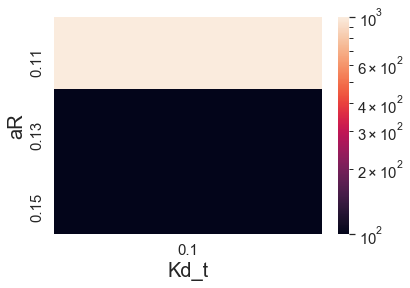

Kd_c 2.08


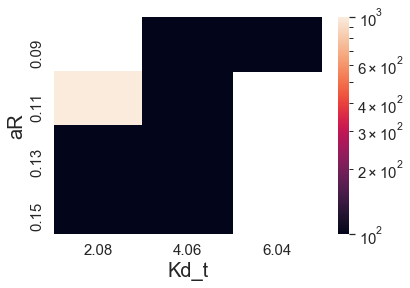

Kd_c 4.06


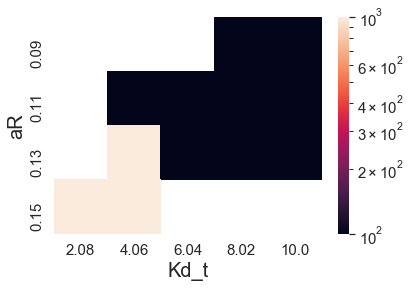

Kd_c 6.04


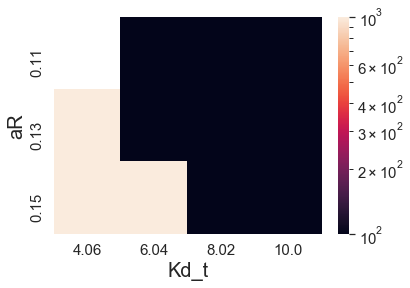

Kd_c 8.02


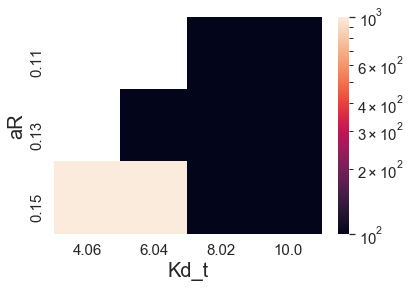

Kd_c 10.0


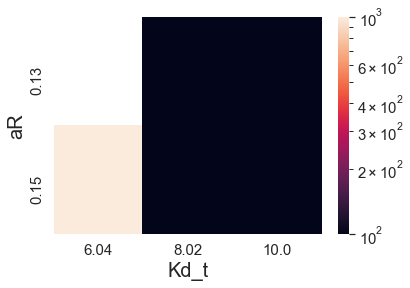

<Figure size 432x288 with 0 Axes>

In [28]:
loopheatmaps(
    values="peak_width",
    index="aR",
    columns="Kd_t",
    loop="Kd_c",
    loopvals=Kd_c_vals
)

# Cis inhibition for peaks that exist

aR 0.09


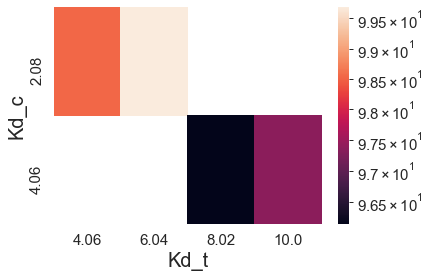

aR 0.11


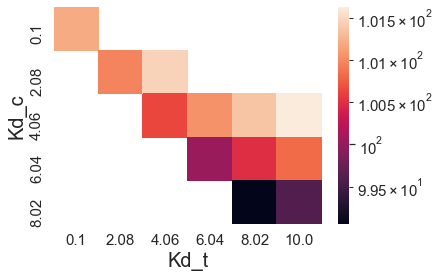

aR 0.13


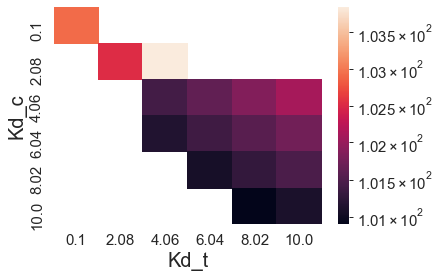

aR 0.15


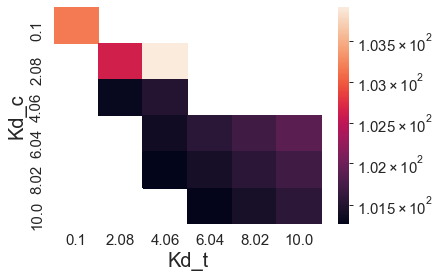

<Figure size 432x288 with 0 Axes>

In [29]:
loopheatmaps(
    values="cis_inh",
    index="Kd_c",
    columns="Kd_t",
    loop="aR",
    loopvals=aR_vals,
    startofloop=2,
    dataset=no_nan_df
)

when Kd_c = Kd_t (dissocation constant for ligands that bind in trans conformation equals dissociation constant for ligands that bind in cis conformation), there are peaks

there is high cis inh when low Kd_C (high affinity of cis ligands w receptor) 

when there is low Kd_t --> high affinity of the trans ligand ... ???

in second graph above, there is high cis inh when very high Kd_t (very low affinity of ligand in trans for the receptor) which makes sense because affinity of ligand in cis is higher --> more receptors are bound in cis conformation and inhibited

when cis inhibition occurs it pretty strong for all Kd_c and Kd_t values 

not much difference along the color scale 

Cis-activation fold-diff: 45.1
Cis-inhibition efficacy: 102.25 %
start of peak 0.631
end of peak 25.1189
peak_width 39.8080824088748
sig change [ 0  0  1 -1  0  0  0]


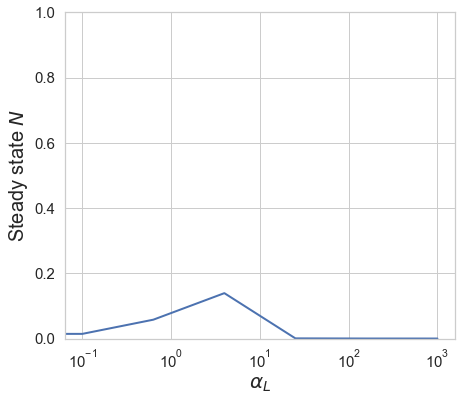

In [30]:
# Define params values that give good fold differences at reasonably high production rates
# Receptor = Notch1, Ligand = Dll4

Kd_t = 4.06
Kd_c = 2.08
aR = 0.15
gR = np.log(2) / .8
dR = 0.01
gT = np.log(2) / .07
# aL = 0.4
gC = gR # setting gC == gR for now
gL = np.log(2) / .3
gN = np.log(2) / 1.25

# Define ligand range for titration- x axis for plot; adding ligands 
aL_vals = np.around(np.logspace(-1, 3, num=6, base=10.0), decimals=4)
aL_vals = np.insert(aL_vals, 0, 0)

circuit_params = (Kd_t, Kd_c, aR, gR, dR, gT, aL_vals[0], gL, gC, gN)

# Define time series
hr = 48.0 # simulation of 48 hours
interval = 5 # 5 minutes between time steps

convergence_crit = 1 # ≤ 1 percent change in 5 minutes = steady state achieved

# Simulate ligand titration
N_vect, cis_act, cis_inh = titrate_ligand(aL_vals, circuit_params, 
                                          hr, interval, convergence_crit)

# Print cis-activation and -inhibition metrics
print('Cis-activation fold-diff:', cis_act)
print('Cis-inhibition efficacy:', cis_inh, '%')

# Added this in to quantify peak width 
peak_width,start_of_peak,end_of_peak=peak_params(aL_vals)
sigchange=significant_change(aL_vals)
    
# Plot
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

plt.plot(aL_vals, N_vect)
plt.ylabel('Steady state $N$')
plt.xlabel('$\\alpha_L$')
plt.ylim((0,1))
ax.set_xscale('log')
print('start of peak', start_of_peak)
print('end of peak',end_of_peak)
print('peak_width',peak_width)
print('sig change',sigchange)

Kd_c 0.1


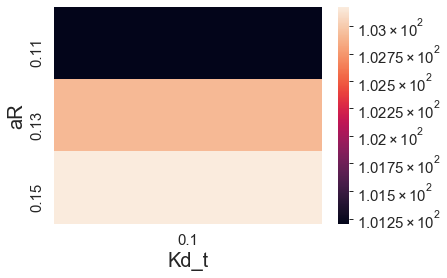

Kd_c 2.08


/Users/cjko/opt/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


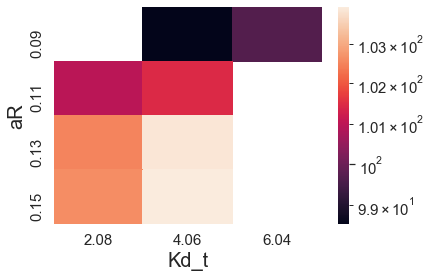

Kd_c 4.06


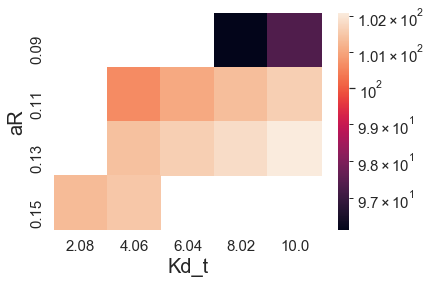

Kd_c 6.04


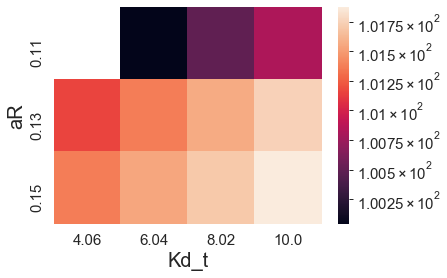

Kd_c 8.02


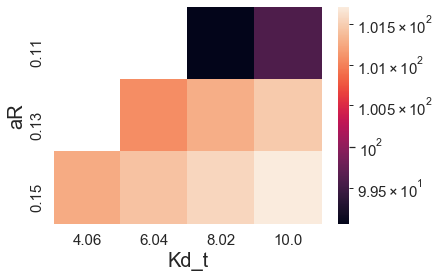

Kd_c 10.0


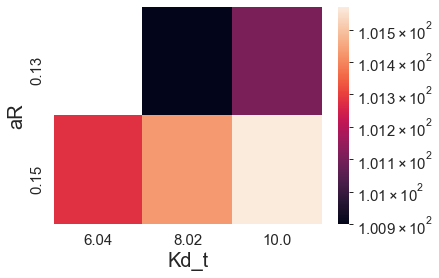

<Figure size 432x288 with 0 Axes>

In [31]:
loopheatmaps(
    values="cis_inh",
    index="aR",
    columns="Kd_t",
    loop="Kd_c",
    loopvals=Kd_c_vals,
    startofloop=0,
    dataset=no_nan_df
)

most peaks when Kd_c = 4.06-6.04 range  because most squares

as Kd_t increases, less affinity of trans ligand --> more cis inhibition 

aR of under 0.11 has low cis inhibition
when production of ligand is too low, there will be low cis inhibition

# Cis activation scale for the data that has a peak

aR 0.09


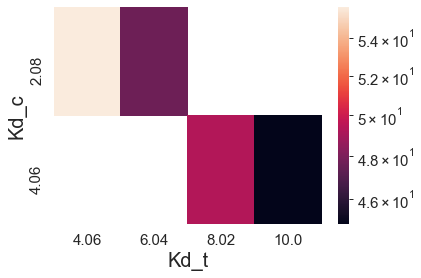

aR 0.11


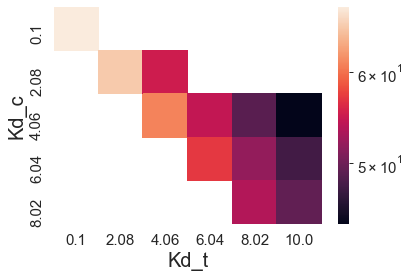

aR 0.13


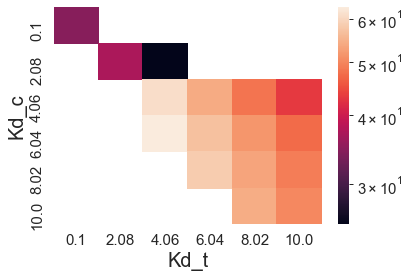

aR 0.15


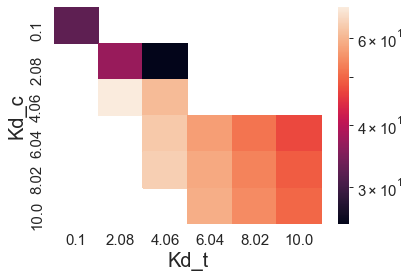

<Figure size 432x288 with 0 Axes>

In [32]:
loopheatmaps(
    values="cis_act",
    index="Kd_c",
    columns="Kd_t",
    loop="aR",
    loopvals=aR_vals,
    startofloop=2,
    dataset=no_nan_df
)

interesting how from aR 0.11 --> 0.13, the dark and light places switched...

when aR < 0.11, low kd_c and low Kd_T give high cis activation 

when aR > 0.13, mid Kd_c and Kd_t give high cis activation (2.08-4.06) 

CREATE BOKEH SLIDER PLOTS FOR N VS. AL; slide aR 


Kd_c 0.1


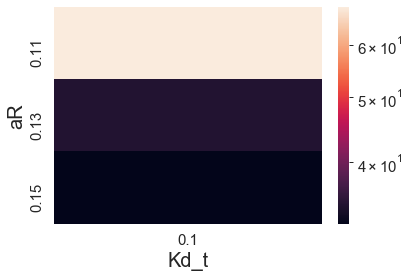

Kd_c 2.08


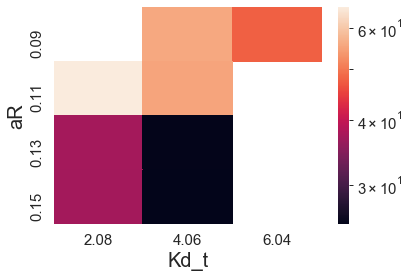

Kd_c 4.06


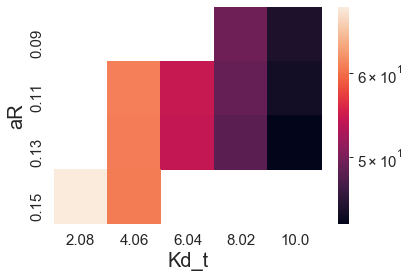

Kd_c 6.04


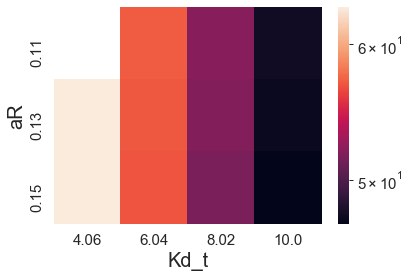

Kd_c 8.02


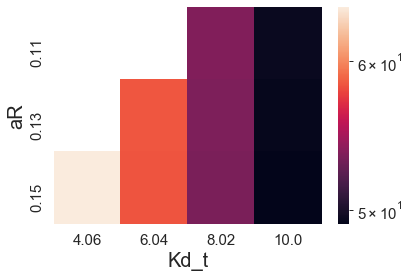

Kd_c 10.0


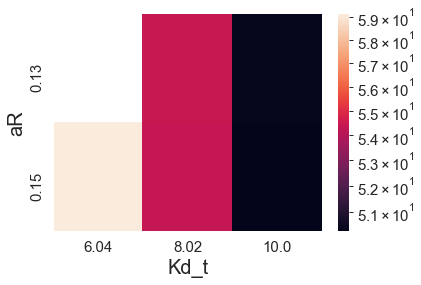

<Figure size 432x288 with 0 Axes>

In [33]:
loopheatmaps(
    values="cis_act",
    index="aR",
    columns="Kd_t",
    loop="Kd_c",
    loopvals=Kd_c_vals,
    startofloop=0,
    dataset=no_nan_df
)

# Varying gR, gC, gL

In [20]:
Kd_t= 2.08
Kd_c = 2.08
aR = .11
gR_vals = np.around(np.log(2) / np.logspace(-1.6, 0.1, num=4, base=10.0),decimals=4) #np.log(2) / .8
dR = 0.01
#dR_vals = np.log(2)/np.around(np.logspace(.7, 1.3, num=4, base=10.0),decimals=4)
gT = np.log(2) / .07
# aL = 0.4
gC_vals = gR_vals # setting gC == gR for now
gL_vals = np.around(np.log(2) / np.logspace(-1.3, .7, num=4, base=10.0),decimals=4)  #np.log(2) / .3
gN = np.log(2) / 1.25

In [21]:
%%time 
# Define params values that give good fold differences at reasonably high production rates
# Receptor = Notch1, Ligand = Dll4

master_array = np.array(())

for gL in gL_vals:
    for gC in gC_vals:
        for gR in gR_vals:

            # Define ligand range for titration- x axis for plot; adding ligands
            aL_vals = np.around(np.logspace(-3, 2, num=6, base=10.0), decimals=4)
            aL_vals = np.insert(aL_vals, 0, 0)

            circuit_params = (Kd_t, Kd_c, aR, gR, dR, gT, aL_vals[0], gL, gC, gN)

            # Define time series
            hr = 48.0  # simulation of 48 hours
            interval = 5  # 5 minutes between time steps

            # ≤ 1 percent change in 5 minutes = steady state achieved
            convergence_crit = 1

            # Simulate ligand titration
            N_vect, cis_act, cis_inh = titrate_ligand(
                aL_vals, circuit_params, hr, interval, convergence_crit
            )

            # Added this in to quantify peak width
            peak_width, startpeak, endpeak = peak_params(aL_vals)
            sig_change=significant_change(aL_vals)

            Kd_t, Kd_c, aR, gR, dR, gT, aL_vals[0], gL, gC, gN = circuit_params

            create_list = [
                Kd_t,
                Kd_c,
                aR,
                gR,
                dR,
                gT,
                aL_vals[0],
                gL,
                gC,
                gN,
                cis_act,
                cis_inh,
                startpeak,
                endpeak,
                peak_width,
                sig_change
            ]

            master_array = np.append(master_array, create_list)

CPU times: user 2min, sys: 1.21 s, total: 2min 1s
Wall time: 2min 2s


In [22]:
rows = master_array.size/16

In [23]:
master_array = master_array.reshape((int(rows),16))

In [24]:
masterdf = pd.DataFrame(master_array)

In [25]:
masterdf.columns = ['Kd_t', 'Kd_c', 'aR', 'gR', 'dR', 'gT', 'aL_vals[0]', 'gL', 'gC', 'gN', 'cis_act','cis_inh', 'startpeak','endpeak','peak_width','sig_change']

In [26]:
masterdf

,Kd_t,Kd_c,aR,gR,dR,gT,aL_vals[0],gL,gC,gN,cis_act,cis_inh,startpeak,endpeak,peak_width,sig_change
0,2.08,2.08,0.11,27.5947,0.01,9.9021,0,13.8301,27.5947,0.554518,343.31,0,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0]"
1,2.08,2.08,0.11,7.4844,0.01,9.9021,0,13.8301,27.5947,0.554518,114.57,0,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0]"
2,2.08,2.08,0.11,2.03,0.01,9.9021,0,13.8301,27.5947,0.554518,36.47,0,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0]"
3,2.08,2.08,0.11,0.5506,0.01,9.9021,0,13.8301,27.5947,0.554518,10.5,0,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0]"
4,2.08,2.08,0.11,27.5947,0.01,9.9021,0,13.8301,7.4844,0.554518,396.89,0,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2.08,2.08,0.11,0.5506,0.01,9.9021,0,0.1383,2.03,0.554518,40.75,0,0.01,NaN,NaN,"[0, 0, 1, 1, 0, 0, 0]"
60,2.08,2.08,0.11,27.5947,0.01,9.9021,0,0.1383,0.5506,0.554518,709.31,0,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0]"
61,2.08,2.08,0.11,7.4844,0.01,9.9021,0,0.1383,0.5506,0.554518,405.77,0,0.1,NaN,NaN,"[0, 0, 0, 1, 0, 0, 0]"
62,2.08,2.08,0.11,2.03,0.01,9.9021,0,0.1383,0.5506,0.554518,157.71,0,0.1,NaN,NaN,"[0, 0, 0, 1, 0, 0, 0]"


In [33]:
def loopheatmaps(values,index,columns,loop,loopvals,startofloop=0,dataset=masterdf):
    """This function is for looping through creating a bunch of heat maps.
    values = what you want the color scale to represent STR
    index=y-axes STR
    columns=x-axis STR 
    loop= the variable staying constant that you are looping through for each map
    loopvals = ^ but the vals array
    startofloop = start of range; default = 0"""
    
    for i in range(startofloop,len(loopvals)):

        df_subset = dataset.loc[(dataset[str(loop)] == np.around(loopvals[i],decimals=4))]

        # I HAD A ROUNDING ERROR ^ BUT FIXED W NP.AROUND

        # I think dependence on aR == aL equivalence is only true for certain gR values. try gR = g_vals[3] vs [1]

        # pandas pivot
        heatmap_data = pd.pivot_table(df_subset, values=str(values), 
                             index=[str(index)], 
                             columns=str(columns))

        print('===============')
        print(str(loop),loopvals[i])
        sns.heatmap(heatmap_data,norm=LogNorm())
        df_subset
        plt.show()
        plt.figure()
        
    

In [36]:
gL_vals

array([13.8301,  2.9796,  0.6419,  0.1383])

In [59]:
loopheatmaps(
    values="cis_inh",
    index="gL",
    columns="gR",
    loop="gC",
    loopvals=gL_vals,
    startofloop=3
)

gC 0.1383


ValueError: zero-size array to reduction operation fmin which has no identity

In [35]:
gL_vals

array([13.8301,  2.9796,  0.6419,  0.1383])

In [134]:
masterdf.loc[(masterdf['Kd_t']==2.08) & 
             (masterdf['gR']==27.5947)]

,index,Kd_t,Kd_c,aR,gR,dR,gT,aL_vals[0],gL,gC,gN,cis_act,cis_inh,startpeak,endpeak,peak_width,sig_change
4,0,2.08,2.08,0.11,27.5947,0.01,9.902103,0.0,13.8301,27.5947,0.554518,343.31,0.0,NaN,NaN,NaN,[0 0 0 0 0 0 0]
8,4,2.08,2.08,0.11,27.5947,0.01,9.902103,0.0,13.8301,7.4844,0.554518,396.89,0.0,NaN,NaN,NaN,[0 0 0 0 0 0 0]
12,8,2.08,2.08,0.11,27.5947,0.01,9.902103,0.0,13.8301,2.0300,0.554518,451.17,0.0,NaN,NaN,NaN,[0 0 0 0 0 0 0]
16,12,2.08,2.08,0.11,27.5947,0.01,9.902103,0.0,13.8301,0.5506,0.554518,468.56,0.0,NaN,NaN,NaN,[0 0 0 0 0 0 0]
19,16,2.08,2.08,0.11,27.5947,0.01,9.902103,0.0,2.9796,27.5947,0.554518,416.07,0.0,NaN,NaN,NaN,[0 0 0 0 0 0 0]
23,20,2.08,2.08,0.11,27.5947,0.01,9.902103,0.0,2.9796,7.4844,0.554518,513.81,0.0,NaN,NaN,NaN,[0 0 0 0 0 0 0]
27,24,2.08,2.08,0.11,27.5947,0.01,9.902103,0.0,2.9796,2.0300,0.554518,608.72,0.0,NaN,NaN,NaN,[0 0 0 0 0 0 0]
31,28,2.08,2.08,0.11,27.5947,0.01,9.902103,0.0,2.9796,0.5506,0.554518,640.87,0.0,NaN,NaN,NaN,[0 0 0 0 0 0 0]
34,32,2.08,2.08,0.11,27.5947,0.01,9.902103,0.0,0.6419,27.5947,0.554518,436.08,0.0,NaN,NaN,NaN,[0 0 0 0 0 0 0]
38,36,2.08,2.08,0.11,27.5947,0.01,9.902103,0.0,0.6419,7.4844,0.554518,548.56,0.0,NaN,NaN,NaN,[0 0 0 0 0 0 0]


In [135]:
masterdf.head()

,index,Kd_t,Kd_c,aR,gR,dR,gT,aL_vals[0],gL,gC,gN,cis_act,cis_inh,startpeak,endpeak,peak_width,sig_change
0,15,2.08,2.08,0.11,0.5506,0.01,9.902103,0.0,13.8301,0.5506,0.554518,36.19,102.17,1.00,100.0,100.0,[ 0 0 0 0 1 -1 -1]
1,31,2.08,2.08,0.11,0.5506,0.01,9.902103,0.0,2.9796,0.5506,0.554518,27.29,103.58,0.10,10.0,100.0,[ 0 0 0 1 -1 0 0]
2,47,2.08,2.08,0.11,0.5506,0.01,9.902103,0.0,0.6419,0.5506,0.554518,41.51,102.44,0.10,10.0,100.0,[ 0 0 0 1 -1 0 0]
3,63,2.08,2.08,0.11,0.5506,0.01,9.902103,0.0,0.1383,0.5506,0.554518,26.66,103.89,0.01,1.0,100.0,[ 0 0 1 -1 0 0 0]
4,0,2.08,2.08,0.11,27.5947,0.01,9.902103,0.0,13.8301,27.5947,0.554518,343.31,0.00,NaN,NaN,NaN,[0 0 0 0 0 0 0]


In [27]:
filename = '/Users/cjko/git/bootcamp/2020-08-02_gs.csv'

masterdf.to_csv(filename, sep = ',', index=False)

### Read in data

In [131]:
file = '/Users/cjko/git/bootcamp/2020-08-02_gs.csv'
masterdf = pd.read_csv(file)

In [132]:
masterdf=masterdf.sort_values(by=['peak_width']).reset_index()

In [39]:
masterdf

,Kd_t,Kd_c,aR,gR,dR,gT,aL_vals[0],gL,gC,gN,cis_act,cis_inh,startpeak,endpeak,peak_width,sig_change
0,2.08,2.08,0.11,27.5947,0.01,9.9021,0,13.8301,27.5947,0.554518,343.31,0,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0]"
1,2.08,2.08,0.11,7.4844,0.01,9.9021,0,13.8301,27.5947,0.554518,114.57,0,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0]"
2,2.08,2.08,0.11,2.03,0.01,9.9021,0,13.8301,27.5947,0.554518,36.47,0,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0]"
3,2.08,2.08,0.11,0.5506,0.01,9.9021,0,13.8301,27.5947,0.554518,10.5,0,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0]"
4,2.08,2.08,0.11,27.5947,0.01,9.9021,0,13.8301,7.4844,0.554518,396.89,0,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2.08,2.08,0.11,0.5506,0.01,9.9021,0,0.1383,2.03,0.554518,40.75,0,0.01,NaN,NaN,"[0, 0, 1, 1, 0, 0, 0]"
60,2.08,2.08,0.11,27.5947,0.01,9.9021,0,0.1383,0.5506,0.554518,709.31,0,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0]"
61,2.08,2.08,0.11,7.4844,0.01,9.9021,0,0.1383,0.5506,0.554518,405.77,0,0.1,NaN,NaN,"[0, 0, 0, 1, 0, 0, 0]"
62,2.08,2.08,0.11,2.03,0.01,9.9021,0,0.1383,0.5506,0.554518,157.71,0,0.1,NaN,NaN,"[0, 0, 0, 1, 0, 0, 0]"


In [85]:
no_nan_df= masterdf[masterdf['peak_width'].notna()]

In [57]:
pd.Series.unique(masterdf['cis_inh'])

array([102.17, 103.58, 102.44, 103.89,   0.  ])

In [88]:
cis_inh_over_zero = masterdf.loc[masterdf['cis_inh']>0]

gL 13.8301


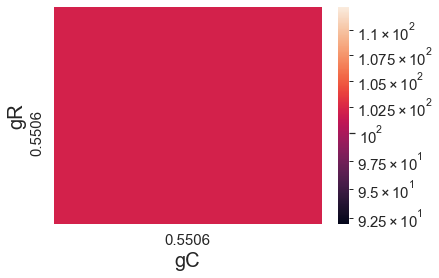

gL 2.9796


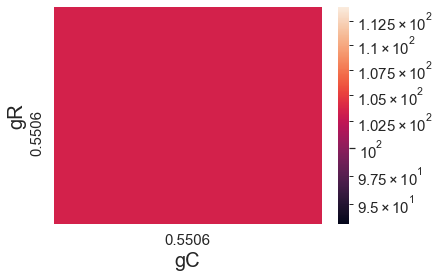

gL 0.6419


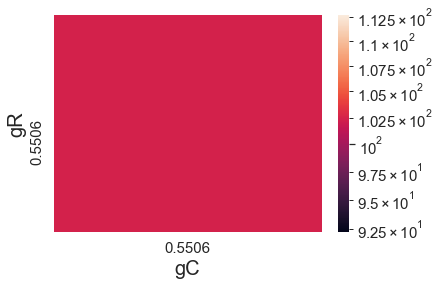

gL 0.1383


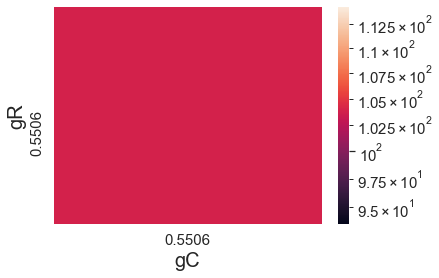

<Figure size 432x288 with 0 Axes>

In [89]:
loopheatmaps(
    values="cis_inh",
    index="gR",
    columns="gC",
    loop="gL",
    loopvals=gL_vals,
    startofloop=0,
    dataset=cis_inh_over_zero
)

In [82]:
masterdf.dtypes

Kd_t          float64
Kd_c          float64
aR            float64
gR            float64
dR            float64
gT            float64
aL_vals[0]    float64
gL            float64
gC            float64
gN            float64
cis_act       float64
cis_inh       float64
startpeak     float64
endpeak       float64
peak_width    float64
sig_change     object
dtype: object

In [81]:
for i,j in enumerate(masterdf.columns):
    if i <15:
        masterdf[str(j)]=pd.to_numeric(masterdf[str(j)])
masterdf

,Kd_t,Kd_c,aR,gR,dR,gT,aL_vals[0],gL,gC,gN,cis_act,cis_inh,startpeak,endpeak,peak_width,sig_change
0,2.08,2.08,0.11,27.5947,0.01,9.902103,0.0,13.8301,27.5947,0.554518,343.31,0.00,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0]"
1,2.08,2.08,0.11,7.4844,0.01,9.902103,0.0,13.8301,27.5947,0.554518,114.57,0.00,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0]"
2,2.08,2.08,0.11,2.0300,0.01,9.902103,0.0,13.8301,27.5947,0.554518,36.47,0.00,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0]"
3,2.08,2.08,0.11,0.5506,0.01,9.902103,0.0,13.8301,27.5947,0.554518,10.50,0.00,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0]"
4,2.08,2.08,0.11,27.5947,0.01,9.902103,0.0,13.8301,7.4844,0.554518,396.89,0.00,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2.08,2.08,0.11,0.5506,0.01,9.902103,0.0,0.1383,2.0300,0.554518,40.75,0.00,0.01,NaN,NaN,"[0, 0, 1, 1, 0, 0, 0]"
60,2.08,2.08,0.11,27.5947,0.01,9.902103,0.0,0.1383,0.5506,0.554518,709.31,0.00,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0]"
61,2.08,2.08,0.11,7.4844,0.01,9.902103,0.0,0.1383,0.5506,0.554518,405.77,0.00,0.10,NaN,NaN,"[0, 0, 0, 1, 0, 0, 0]"
62,2.08,2.08,0.11,2.0300,0.01,9.902103,0.0,0.1383,0.5506,0.554518,157.71,0.00,0.10,NaN,NaN,"[0, 0, 0, 1, 0, 0, 0]"


In [142]:
gL_vals

array([13.8301,  2.9796,  0.6419,  0.1383])

In [141]:
masterdf.loc[masterdf['gL']==27.5947]

,index,Kd_t,Kd_c,aR,gR,dR,gT,aL_vals[0],gL,gC,gN,cis_act,cis_inh,startpeak,endpeak,peak_width,sig_change
4,0,2.08,2.08,0.11,27.5947,0.01,9.902103,0.0,13.8301,27.5947,0.554518,343.31,0.0,NaN,NaN,NaN,[0 0 0 0 0 0 0]
5,1,2.08,2.08,0.11,7.4844,0.01,9.902103,0.0,13.8301,27.5947,0.554518,114.57,0.0,NaN,NaN,NaN,[0 0 0 0 0 0 0]
6,2,2.08,2.08,0.11,2.0300,0.01,9.902103,0.0,13.8301,27.5947,0.554518,36.47,0.0,NaN,NaN,NaN,[0 0 0 0 0 0 0]
7,3,2.08,2.08,0.11,0.5506,0.01,9.902103,0.0,13.8301,27.5947,0.554518,10.50,0.0,NaN,NaN,NaN,[0 0 0 0 0 0 0]
19,16,2.08,2.08,0.11,27.5947,0.01,9.902103,0.0,2.9796,27.5947,0.554518,416.07,0.0,NaN,NaN,NaN,[0 0 0 0 0 0 0]
20,17,2.08,2.08,0.11,7.4844,0.01,9.902103,0.0,2.9796,27.5947,0.554518,122.55,0.0,NaN,NaN,NaN,[0 0 0 0 0 0 0]
21,18,2.08,2.08,0.11,2.0300,0.01,9.902103,0.0,2.9796,27.5947,0.554518,37.22,0.0,NaN,NaN,NaN,[0 0 0 0 0 0 0]
22,19,2.08,2.08,0.11,0.5506,0.01,9.902103,0.0,2.9796,27.5947,0.554518,10.56,0.0,NaN,NaN,NaN,[0 0 0 0 0 0 0]
34,32,2.08,2.08,0.11,27.5947,0.01,9.902103,0.0,0.6419,27.5947,0.554518,436.08,0.0,NaN,NaN,NaN,[0 0 0 0 0 0 0]
35,33,2.08,2.08,0.11,7.4844,0.01,9.902103,0.0,0.6419,27.5947,0.554518,124.42,0.0,NaN,NaN,NaN,[0 0 0 0 0 0 0]


gC 27.5947


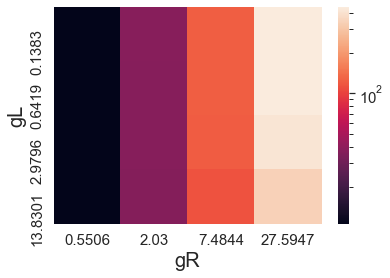

gC 7.4844


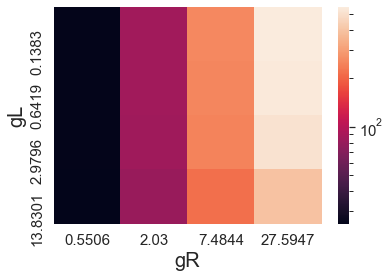

gC 2.03


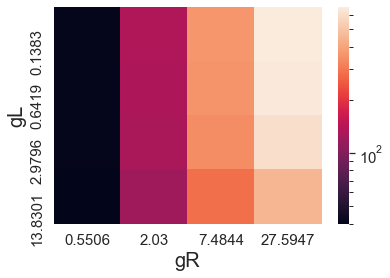

gC 0.5506


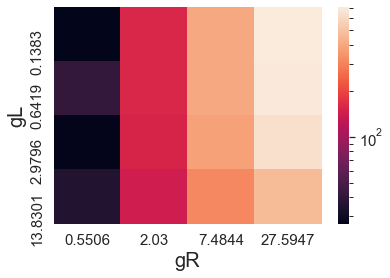

<Figure size 432x288 with 0 Axes>

In [96]:
loopheatmaps(
    values="cis_act",
    index="gL",
    columns="gR",
    loop="gC",
    loopvals=gC_vals
)

cis activation varies heavily with the gR and not so much with gC or gL (endocytosis of the ligand and endocytosis of hte cis complex)

gC 0.5506


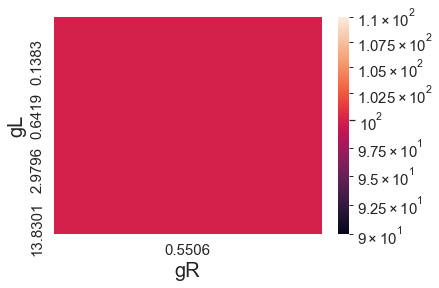

<Figure size 432x288 with 0 Axes>

In [95]:
loopheatmaps(
    values="peak_width",
    index="gL",
    columns="gR",
    loop="gC",
    loopvals=gC_vals,
    startofloop=3
)

only with gC of 0.5506 is there a peak 

# Varying dR, gT

In [105]:
Kd_t= 2.08
Kd_c = 2.08
aR = .11
gR = np.log(2) / .8
dR_vals = np.around(np.log(2)/np.logspace(.7, 1.3, num=6, base=10.0),decimals=4)
gT_vals = np.around(np.log(2) / np.logspace(-1.6, 0.1, num=6, base=10.0),decimals=4)
#gT = np.log(2) / .07
# aL = 0.4
gC = gR # setting gC == gR for now
gL = np.log(2) / .3
gN = np.log(2) / 1.25

In [106]:
%%time 
# Define params values that give good fold differences at reasonably high production rates
# Receptor = Notch1, Ligand = Dll4

master_array = np.array(())

for dR in dR_vals:
    for gT in gT_vals:

        # Define ligand range for titration- x axis for plot; adding ligands
        aL_vals = np.around(np.logspace(-3, 2, num=6, base=10.0), decimals=4)
        aL_vals = np.insert(aL_vals, 0, 0)

        circuit_params = (Kd_t, Kd_c, aR, gR, dR, gT, aL_vals[0], gL, gC, gN)

        # Define time series
        hr = 48.0  # simulation of 48 hours
        interval = 5  # 5 minutes between time steps

        # ≤ 1 percent change in 5 minutes = steady state achieved
        convergence_crit = 1

        # Simulate ligand titration
        N_vect, cis_act, cis_inh = titrate_ligand(
            aL_vals, circuit_params, hr, interval, convergence_crit
        )

        # Added this in to quantify peak width
        peak_width, startpeak, endpeak = peak_params(aL_vals)
        sig_change=significant_change(aL_vals)

        Kd_t, Kd_c, aR, gR, dR, gT, aL_vals[0], gL, gC, gN = circuit_params

        create_list = [
            Kd_t,
            Kd_c,
            aR,
            gR,
            dR,
            gT,
            aL_vals[0],
            gL,
            gC,
            gN,
            cis_act,
            cis_inh,
            startpeak,
            endpeak,
            peak_width,
            sig_change
        ]

        master_array = np.append(master_array, create_list)

CPU times: user 1min 12s, sys: 775 ms, total: 1min 13s
Wall time: 1min 15s


In [107]:
rows = master_array.size/16

In [108]:
master_array = master_array.reshape((int(rows),16))

In [109]:
masterdf = pd.DataFrame(master_array)

In [110]:
masterdf.columns = ['Kd_t', 'Kd_c', 'aR', 'gR', 'dR', 'gT', 'aL_vals[0]', 'gL', 'gC', 'gN', 'cis_act','cis_inh', 'startpeak','endpeak','peak_width','sig_change']

In [111]:
masterdf.head()

,Kd_t,Kd_c,aR,gR,dR,gT,aL_vals[0],gL,gC,gN,cis_act,cis_inh,startpeak,endpeak,peak_width,sig_change
0,2.08,2.08,0.11,0.866434,0.1383,27.5947,0,2.31049,0.866434,0.554518,6.71,0,0.1,NaN,NaN,"[0, 0, 0, 1, 0, 0, 0]"
1,2.08,2.08,0.11,0.866434,0.1383,12.6132,0,2.31049,0.866434,0.554518,6.14,0,0.1,NaN,NaN,"[0, 0, 0, 1, 1, 0, 0]"
2,2.08,2.08,0.11,0.866434,0.1383,5.7653,0,2.31049,0.866434,0.554518,4.64,125.57,1,100,100,"[0, 0, 0, 0, 1, -1, -1]"
3,2.08,2.08,0.11,0.866434,0.1383,2.6353,0,2.31049,0.866434,0.554518,3.13,144.19,NaN,100,NaN,"[0, 0, 0, 0, 0, -1, -1]"
4,2.08,2.08,0.11,0.866434,0.1383,1.2046,0,2.31049,0.866434,0.554518,1.33,383.14,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0]"


In [112]:
filename = '/Users/cjko/git/bootcamp/2020-08-02_dR_gT.csv'

masterdf.to_csv(filename, sep = ',', index=False)

### Read in data

In [113]:
file = '/Users/cjko/git/bootcamp/2020-08-02_dR_gT.csv'
masterdf = pd.read_csv(file)

In [114]:
masterdf=masterdf.sort_values(by=['peak_width']).reset_index()

In [115]:
masterdf.head()

,index,Kd_t,Kd_c,aR,gR,dR,gT,aL_vals[0],gL,gC,gN,cis_act,cis_inh,startpeak,endpeak,peak_width,sig_change
0,2,2.08,2.08,0.11,0.866434,0.1383,5.7653,0.0,2.310491,0.866434,0.554518,4.64,125.57,1.0,100.0,100.0,[ 0 0 0 0 1 -1 -1]
1,8,2.08,2.08,0.11,0.866434,0.1049,5.7653,0.0,2.310491,0.866434,0.554518,5.90,118.95,1.0,100.0,100.0,[ 0 0 0 0 1 -1 -1]
2,14,2.08,2.08,0.11,0.866434,0.0796,5.7653,0.0,2.310491,0.866434,0.554518,7.55,114.10,1.0,100.0,100.0,[ 0 0 0 0 1 -1 -1]
3,20,2.08,2.08,0.11,0.866434,0.0604,5.7653,0.0,2.310491,0.866434,0.554518,9.73,110.50,1.0,100.0,100.0,[ 0 0 0 0 1 -1 -1]
4,26,2.08,2.08,0.11,0.866434,0.0458,5.7653,0.0,2.310491,0.866434,0.554518,12.62,107.82,1.0,100.0,100.0,[ 0 0 0 0 1 -1 -1]


In [116]:
no_nan_df= masterdf[masterdf['peak_width'].notna()]

In [117]:
positive= masterdf.loc[masterdf['cis_inh']>0]
positive

,index,Kd_t,Kd_c,aR,gR,dR,gT,aL_vals[0],gL,gC,gN,cis_act,cis_inh,startpeak,endpeak,peak_width,sig_change
0,2,2.08,2.08,0.11,0.866434,0.1383,5.7653,0.0,2.310491,0.866434,0.554518,4.64,125.57,1.0,100.0,100.0,[ 0 0 0 0 1 -1 -1]
1,8,2.08,2.08,0.11,0.866434,0.1049,5.7653,0.0,2.310491,0.866434,0.554518,5.90,118.95,1.0,100.0,100.0,[ 0 0 0 0 1 -1 -1]
2,14,2.08,2.08,0.11,0.866434,0.0796,5.7653,0.0,2.310491,0.866434,0.554518,7.55,114.10,1.0,100.0,100.0,[ 0 0 0 0 1 -1 -1]
3,20,2.08,2.08,0.11,0.866434,0.0604,5.7653,0.0,2.310491,0.866434,0.554518,9.73,110.50,1.0,100.0,100.0,[ 0 0 0 0 1 -1 -1]
4,26,2.08,2.08,0.11,0.866434,0.0458,5.7653,0.0,2.310491,0.866434,0.554518,12.62,107.82,1.0,100.0,100.0,[ 0 0 0 0 1 -1 -1]
5,32,2.08,2.08,0.11,0.866434,0.0347,5.7653,0.0,2.310491,0.866434,0.554518,16.44,105.80,1.0,100.0,100.0,[ 0 0 0 0 1 -1 -1]
8,3,2.08,2.08,0.11,0.866434,0.1383,2.6353,0.0,2.310491,0.866434,0.554518,3.13,144.19,NaN,100.0,NaN,[ 0 0 0 0 0 -1 -1]
9,4,2.08,2.08,0.11,0.866434,0.1383,1.2046,0.0,2.310491,0.866434,0.554518,1.33,383.14,NaN,NaN,NaN,[0 0 0 0 0 0 0]
10,5,2.08,2.08,0.11,0.866434,0.1383,0.5506,0.0,2.310491,0.866434,0.554518,1.08,1269.98,NaN,NaN,NaN,[0 0 0 0 0 0 0]
13,9,2.08,2.08,0.11,0.866434,0.1049,2.6353,0.0,2.310491,0.866434,0.554518,2.14,182.15,NaN,NaN,NaN,[0 0 0 0 0 0 0]


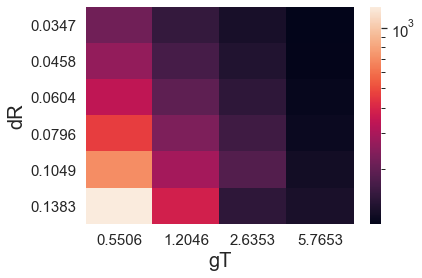

In [118]:
# I HAD A ROUNDING ERROR ^ BUT FIXED W NP.AROUND

# I think dependence on aR == aL equivalence is only true for certain gR values. try gR = g_vals[3] vs [1]

# pandas pivot
heatmap_data = pd.pivot_table(positive, values='cis_inh', 
                     index=['dR'], 
                     columns='gT')

sns.heatmap(heatmap_data,norm=LogNorm())
plt.show()

cis inhibition is high when low activation rates and high leaky receptor activation 

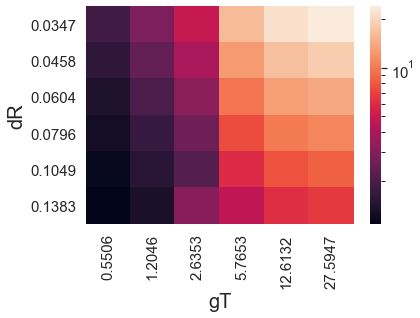

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [119]:
# I HAD A ROUNDING ERROR ^ BUT FIXED W NP.AROUND

# I think dependence on aR == aL equivalence is only true for certain gR values. try gR = g_vals[3] vs [1]

# pandas pivot
heatmap_data = pd.pivot_table(masterdf, values='cis_act', 
                     index=['dR'], 
                     columns='gT')

sns.heatmap(heatmap_data,norm=LogNorm())
plt.show()
plt.figure()

cis activation is high when activation rate are high and when there is low leaky receptor 

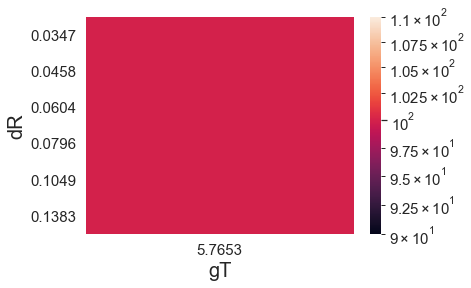

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [121]:
# I HAD A ROUNDING ERROR ^ BUT FIXED W NP.AROUND

# I think dependence on aR == aL equivalence is only true for certain gR values. try gR = g_vals[3] vs [1]

# pandas pivot
heatmap_data = pd.pivot_table(masterdf, values='peak_width', 
                     index=['dR'], 
                     columns='gT')

sns.heatmap(heatmap_data,norm=LogNorm())
plt.show()
plt.figure()

only gT of 5.7653 give a peak width... does matter much about dR 

is possible  if peak width varies more strongly and is more dependent on the other fixed vars 

explore cis act and cis inh show not look like this 